In [1]:
import numpy as np
import nengo
from nengo.dists import Choice, Uniform
from nengo.solvers import NoSolver
import matplotlib.pyplot as plt
import seaborn

In [2]:
def make_US_CS_arrays(pairings=3, dt=0.001, seed=0):  # times measured in seconds
    rng = np.random.RandomState(seed=seed)
    pt = 2  # empty time pre-tone
    tt = 3  # tone time
    ps = 4  # empty time pre-shock
    st = 1  # shock time
    wt = 5  # delay time
    at = 5  # active time
    assert at == pt+tt == ps+st, "stimulus times unaligned"
    CS_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    US_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    for i in range(pairings):
        CS_array[int(i*(wt+at)/dt) : int((i*(wt+at)+pt)/dt)] = 0  # nothing
        US_array[int(i*(wt+at)/dt) : int((i*(wt+at)+ps)/dt)] = 0  # nothing
        CS_array[int((i*(wt+at)+pt)/dt) : int((i*(wt+at)+pt+tt)/dt)] = 1  # tone
        US_array[int((i*(wt+at)+ps)/dt) : int((i*(wt+at)+ps+st)/dt)] = 1  # shock
        CS_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
        US_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
    return CS_array, US_array

# Model

In [3]:
def go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func, seed=0, 
       oxy_func=lambda t: 0.5, vaso_func=lambda t: 1, musc_CeL_func=lambda t: 0, musc_CeM_func=lambda t: 0, BLA_GABA_func=lambda t: 0.5):
    
    model = nengo.Network(seed=seed)
    model.config[nengo.Connection].synapse = 0.02
    model.config[nengo.Probe].synapse = 0.02
    with model:
        # Nodes
        tone_inpt = nengo.Node(tone_func)  # CS input
        shock_inpt = nengo.Node(shock_func)  # US input
        context_inpt = nengo.Node(context_func)
        oxy_inpt = nengo.Node(oxy_func)  # default excitation of CeL neurons that inhibit CeM, maintaining movement via disinhibition
        vaso_inpt = nengo.Node(vaso_func)  # default excitation of CeM neurons, causing default freezing
        motor_inpt = nengo.Node(1)  # default excitation of PAG neurons, causing movement
        BLA_GABA_inpt = nengo.Node(BLA_GABA_func)
        musc_CeL_inpt = nengo.Node(musc_CeL_func)
        musc_CeM_inpt = nengo.Node(musc_CeM_func)
        
        # Ensembles
        # outside amydgala
        thalamus = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='thalamus')
        auditory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='auditory cortex')
        sensory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='sensory_cortex')
        spinal_cord = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='spinal cord')
        hippocampus = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='hippocampus')
        PAG = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='PAG')  # [move]
        # central amygdala
        CeL_in = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='CeL_in')  # [tone, shock]
        CeL_out = nengo.Ensemble(400, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeL_out')  # [move]
        CeM = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeM')  # [freeze]
        error_CeL = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL')
        # lateral amygdala
        LA = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='LA')  # [tone, shock]
        error_LA = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_LA')
        # basal amygdala
        BA = nengo.Ensemble(600, 3, label='BA')  # [tone (from LA), shock, context]
        error_BA_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_BA_pos')
        error_BA_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_BA_neg')
        BLA_GABA = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='BLA_GABA')

        # Connections
        # inputs and outputs
        nengo.Connection(tone_inpt, thalamus)
        nengo.Connection(shock_inpt, spinal_cord)
        nengo.Connection(tone_inpt, auditory_cortex)
        nengo.Connection(shock_inpt, sensory_cortex)
        nengo.Connection(context_inpt, hippocampus)
        nengo.Connection(oxy_inpt, CeL_out)
        nengo.Connection(vaso_inpt, CeM)
        nengo.Connection(motor_inpt, PAG)
        # central amygdala
        thal_CeL = nengo.Connection(thalamus, CeL_in[0], solver=NoSolver(d_thal_CeL), learning_rule_type=nengo.PES(3e-6))  # learning tone-fear
        nengo.Connection(spinal_cord, CeL_in[1])
        nengo.Connection(CeL_in[0], CeL_out, transform=-0.75)  # activate freezing via dis-dis-inhibition
        nengo.Connection(CeL_out, CeL_in[0], transform=-0.5)  # recurrent inhibition allows oxy control of learning
        nengo.Connection(CeL_out, CeL_in[1], transform=-0.5)  # recurrent inhibition allows oxy control of learning
        nengo.Connection(CeL_out, CeM, transform=-1)  # inhibit default freezing
        nengo.Connection(CeL_in, error_CeL, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed later)
        nengo.Connection(error_CeL, thal_CeL.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(CeM, PAG, transform=-1)
        # lateral amygdala
        cortex_LA = nengo.Connection(auditory_cortex, LA[0], solver=NoSolver(d_cortex_LA), learning_rule_type=nengo.PES(3e-6))  # learning tone-fear
        nengo.Connection(sensory_cortex, LA[1])
        nengo.Connection(LA[0], BA[0])  # forwarding 
        nengo.Connection(LA[1], BA[1])  # forwarding
        nengo.Connection(LA, error_LA, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed later)
        nengo.Connection(error_LA, cortex_LA.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(BLA_GABA, LA[0], transform=-0.25)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, LA[1], transform=-0.25)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, error_LA, transform=-0.25)  # GABAergic inhibition
        # basal amygdala
#         hippo_BA = nengo.Connection(hippocampus, BA[2], solver=NoSolver(d_hippo_BA), learning_rule_type=nengo.PES(3e-6))  # learning context-fear/extinct
        hippo_BA = nengo.Connection(hippocampus.neurons, BA[2], transform=d_hippo_BA.T, learning_rule_type=nengo.PES(3e-6))  # learning context-fear/extinct
        nengo.Connection(BA, error_BA_pos, function=lambda x: x[1]-x[2])  # error = shock - tone (reversed below)
        nengo.Connection(error_BA_pos, hippo_BA.learning_rule, transform=-1)  # context-fear association, error = tone - shock
        nengo.Connection(BA, error_BA_neg, function=lambda x: x[0]-x[1])  # error = tone - shock
        nengo.Connection(error_BA_neg, hippo_BA.learning_rule, transform=0.25)  # context-extinct association, smaller learning rate than context-fear
        nengo.Connection(BLA_GABA, BA[0], transform=-0.25)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, BA[1], transform=-0.25)  # GABAergic inhibition
        nengo.Connection(BLA_GABA, BA[2], transform=-0.25)  # GABAergic inhibition
        nengo.Connection(BA, CeM, function=lambda x: 0.5*(x[0]+x[2])) # average of tone and context response
        nengo.Connection(BA, CeL_in[0], function=lambda x: 0.5*(x[0]+x[2])) # average of tone and context response
        # pharmacology
        nengo.Connection(BLA_GABA_inpt, BLA_GABA)
        nengo.Connection(musc_CeL_inpt, CeL_in.neurons, transform=np.ones((CeL_in.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, CeL_out.neurons, transform=np.ones((CeL_out.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, error_CeL.neurons, transform=np.ones((error_CeL.n_neurons, 1)))
        nengo.Connection(musc_CeM_inpt, CeM.neurons, transform=np.ones((CeM.n_neurons, 1)))
        
        # Probes
        p_thalamus = nengo.Probe(thalamus)
        p_spinal_cord = nengo.Probe(spinal_cord)
        p_auditory_cortex = nengo.Probe(auditory_cortex)
        p_sensory_cortex = nengo.Probe(sensory_cortex)
        p_CeL_in = nengo.Probe(CeL_in)  
        p_CeL_out = nengo.Probe(CeL_out)
        p_CeM = nengo.Probe(CeM)
        p_LA = nengo.Probe(LA)
        p_BA = nengo.Probe(BA)
        p_BLA_GABA = nengo.Probe(BLA_GABA)
        p_PAG = nengo.Probe(PAG)
        p_error_CeL = nengo.Probe(error_CeL)
        p_error_LA = nengo.Probe(error_LA)
        p_error_BA_pos = nengo.Probe(error_BA_pos)
        p_error_BA_neg = nengo.Probe(error_BA_neg)
        p_thal_CeL = nengo.Probe(thal_CeL, 'weights', synapse=None)
        p_cortex_LA = nengo.Probe(cortex_LA, 'weights', synapse=None)
        p_hippo_BA = nengo.Probe(hippo_BA, 'weights', synapse=None)
        
    sim = nengo.Simulator(model, seed=seed)
    with sim:
        sim.run(t)
        
    return dict(
        times = sim.trange(),
        thalamus = sim.data[p_thalamus],
        spinal_cord = sim.data[p_spinal_cord],
        auditory_cortex = sim.data[p_auditory_cortex],
        sensory_cortex = sim.data[p_sensory_cortex],
        CeL_in = sim.data[p_CeL_in],
        CeL_out = sim.data[p_CeL_out],
        LA = sim.data[p_LA],
        BA = sim.data[p_BA],
        BLA_GABA = sim.data[p_BLA_GABA],
        CeM = sim.data[p_CeM],
        PAG = sim.data[p_PAG],
        error_CeL = sim.data[p_error_CeL],
        error_LA = sim.data[p_error_LA],
        error_BA_pos = sim.data[p_error_BA_pos],
        error_BA_neg = sim.data[p_error_BA_neg],
        thal_CeL = sim.data[p_thal_CeL][-1].T,
        cortex_LA = sim.data[p_cortex_LA][-1].T,
        hippo_BA = sim.data[p_hippo_BA][-1].T,
    )

# Simulations

## Pre-training Experiments

In [4]:
d_thal_CeL = np.zeros((200, 1))
d_cortex_LA = np.zeros((200, 1))
d_hippo_BA = np.zeros((400, 1))
tone_func = lambda t: 0
shock_func = lambda t: 0
context_func = lambda t: [1, 0]

### Activation of CeM induces spontaneous freezing
Optogenetically activating CeM neurons elicits freezing (Ciocchi et al., 2010). Since CeM expresses vasopressin receptors (Huber et al. 2015), application of this neuropeptide should have a similar effect (look for citation).

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

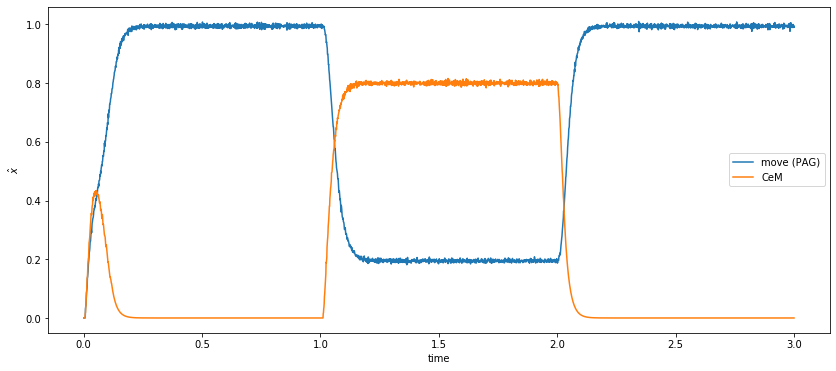

In [5]:
t = 3
vaso_func = lambda t: 2 if 1<t<2 else 1

data = go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func,
    vaso_func=vaso_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Inctivation of CeL induces spontaneous freezing
GABA_A receptor agonist (muscimol-bodipy (BPY)) applied to CeL alone induced spontaneous freezing (Ciocchi et al, 2010)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

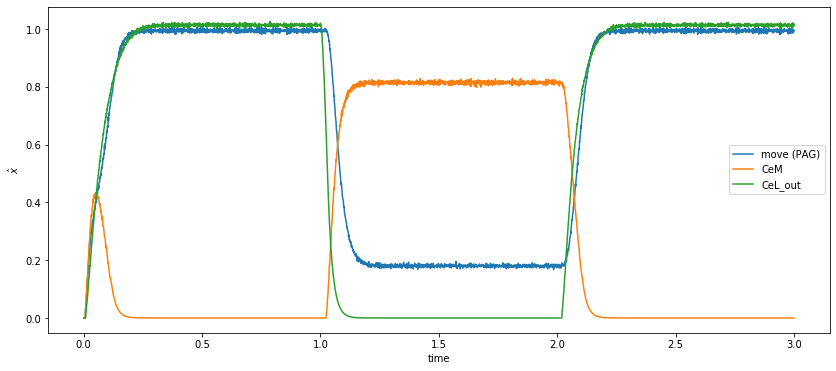

In [6]:
t = 3
musc_CeL_func = lambda t: -1 if 1<t<2 else 0

data = go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func,
    musc_CeL_func=musc_CeL_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

## During training experiments

### Control

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


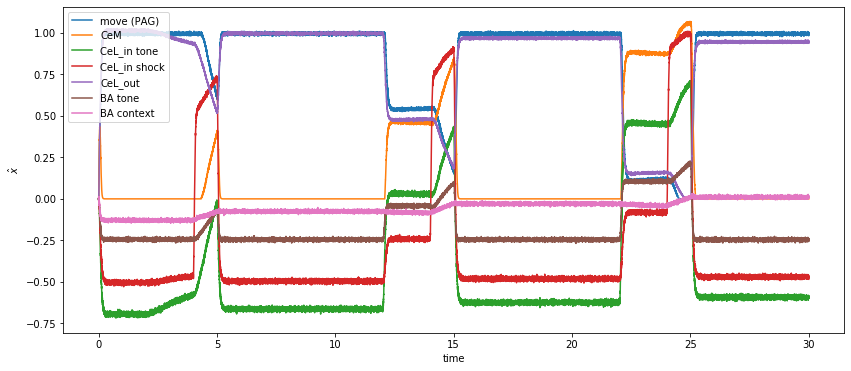

In [7]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=1+int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
context_func = lambda t: [1, 0]

d_thal_CeL = np.zeros((200, 1))
d_cortex_LA = np.zeros((200, 1))
d_hippo_BA = np.zeros((400, 1))

data = go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func)

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_hippo_BA = data['hippo_BA']

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

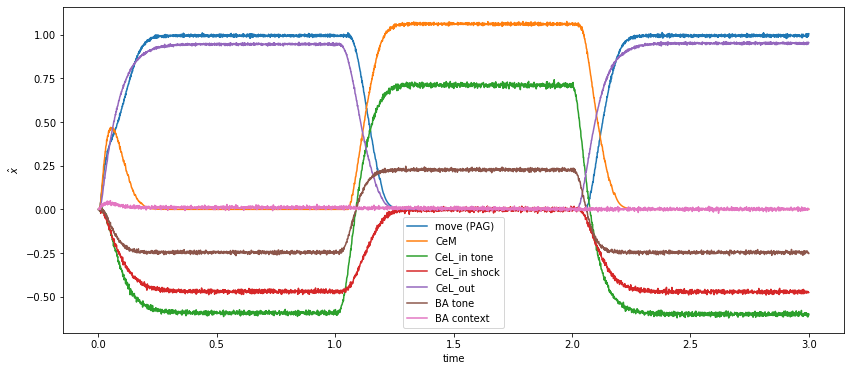

In [8]:
tone_func = lambda t: 1 if 1<t<2 else 0
shock_func = lambda t: 0
context_func = lambda t: [1, 0]

data = go(3, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Inactivation of CeL during training impairs fear conditioning
Muscimol (Ciocchi et al., 2010)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

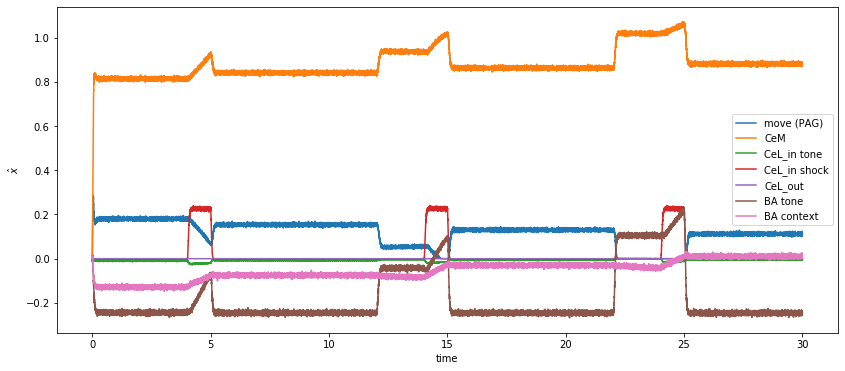

In [9]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=1+int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
context_func = lambda t: [1, 0]
musc_CeL_func = lambda t: -1

d_thal_CeL = np.zeros((200, 1))
d_cortex_LA = np.zeros((200, 1))
d_hippo_BA = np.zeros((400, 1))


data = go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func,
    musc_CeL_func=musc_CeL_func)

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_hippo_BA = data['hippo_BA']

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

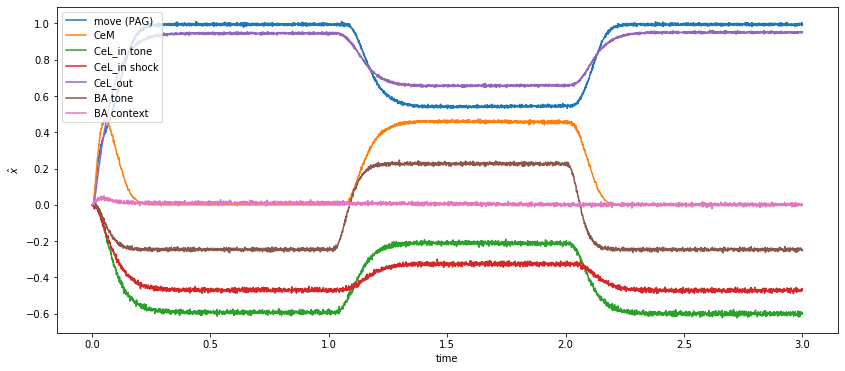

In [10]:
tone_func = lambda t: 1 if 1<t<2 else 0
shock_func = lambda t: 0
context_func = lambda t: [1, 0]

data = go(3, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Applying oxytocin to CeL during conditioning does not affect learning
Viviani et al., 2011

todo: applying oxytocin during testing does affect conditioned freezing Knobloch et al., 2012

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

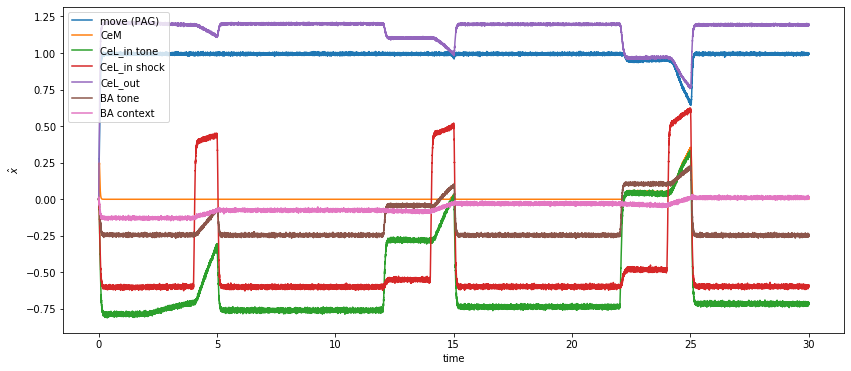

In [11]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=1+int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
context_func = lambda t: [1, 0]
oxy_func = lambda t: 1

d_thal_CeL = np.zeros((200, 1))
d_cortex_LA = np.zeros((200, 1))
d_hippo_BA = np.zeros((400, 1))

data = go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func,
    oxy_func=oxy_func)

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_hippo_BA = data['hippo_BA']

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

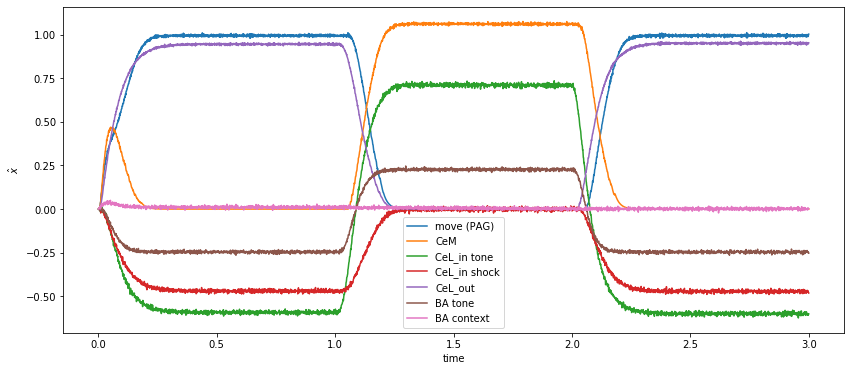

In [12]:
tone_func = lambda t: 1 if 1<t<2 else 0
shock_func = lambda t: 0
context_func = lambda t: [1, 0]

data = go(3, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Inactivation of GABAergic interneurons in BLA facilitates fear conditoning
Dopamine and Norepinephrine are natural neuromodulators of inhibition in BLA, and their presence is implicated in the aquisition of conditioned fear (Bush et al., 2010; Greba et al., 2001; Guarraci et al., 1999; Nader and LeDoux, 1999)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

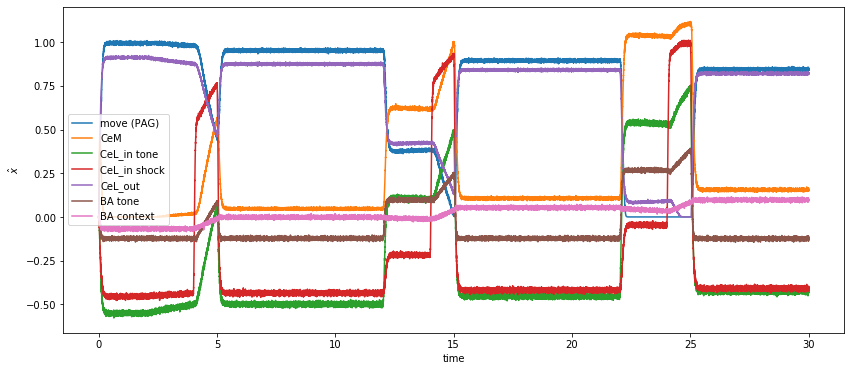

In [14]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=1+int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
context_func = lambda t: [1, 0]
BLA_GABA_func = lambda t: 0.25

d_thal_CeL = np.zeros((200, 1))
d_cortex_LA = np.zeros((200, 1))
d_hippo_BA = np.zeros((400, 1))

data = go(t, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func,
    BLA_GABA_func=BLA_GABA_func)

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_hippo_BA = data['hippo_BA']

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

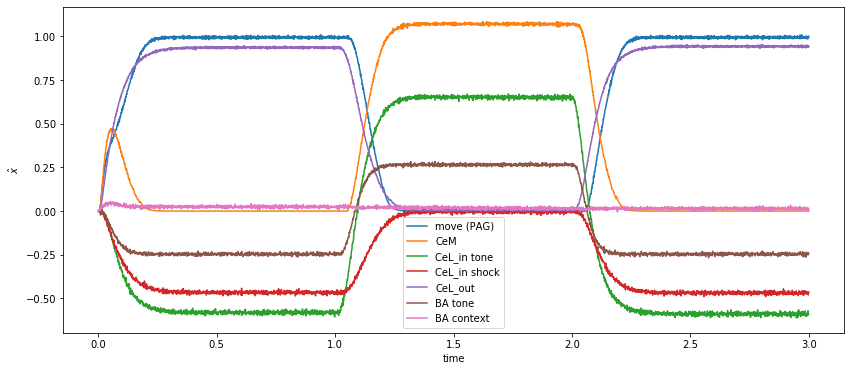

In [15]:
tone_func = lambda t: 1 if 1<t<2 else 0
shock_func = lambda t: 0
context_func = lambda t: [1, 0]

data = go(3, d_thal_CeL, d_cortex_LA, d_hippo_BA, tone_func, shock_func, context_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['BA'][:,0], label='BA tone')
ax.plot(data['times'], data['BA'][:,2], label='BA context')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()